In [30]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [31]:
BATCH_SIZE = 16
IMAGE_SIZE = 150

In [32]:
# import os
# def safe_decode(path):
#     try:
#         return path.encode('utf-8', 'surrogateescape').decode('utf-8')
#     except UnicodeDecodeError:
#         print(f"UnicodeDecodeError: Cannot decode path: {path}")
#         return None


# # Example path to your dataset directory (adjust as per your setup)
# dataset_path = "./dataset_2"

# # Print decoded paths for debugging
# decoded_paths = [safe_decode(os.path.join(dataset_path, subdir)) for subdir in os.listdir(dataset_path)]
# print(decoded_paths)

In [33]:
# import os

# def safe_decode(path):
#     try:
#         return path.encode('utf-8', 'surrogateescape').decode('utf-8')
#     except UnicodeDecodeError:
#         print(f"UnicodeDecodeError: Cannot decode path: {path}")
#         return None

# # Example path to your dataset directory (adjust as per your setup)
# dataset_path = "./dataset_2"

# # Print decoded paths for debugging
# decoded_paths = [safe_decode(os.path.join(dataset_path, subdir)) for subdir in os.listdir(dataset_path)]
# print(decoded_paths)

# # Print directory names and filenames within each directory
# for subdir in os.listdir(dataset_path):
#     subdir_path = os.path.join(dataset_path, subdir)
#     if os.path.isdir(subdir_path):
#         print(f"Directory: {subdir}")
#         for file_name in os.listdir(subdir_path):
#             print(f" - {file_name}")

In [34]:
# import os

# # Path to your dataset directory
# dataset_path = "./dataset_2"

# # Function to recursively rename files in subdirectories
# def rename_files_recursive(directory):
#     count = 1
#     for root, _, files in os.walk(directory):
#         for filename in files:
#             file_path = os.path.join(root, filename)
#             # Ensure the file is an image file (you can modify this check based on your file extensions)
#             if any(file_path.endswith(extension) for extension in ['.jpg', '.jpeg', '.png']):
#                 # Construct new filename, for example: "image_001.jpg"
#                 new_filename = f"image_{count:03}.jpg"
#                 new_file_path = os.path.join(root, new_filename)
#                 os.rename(file_path, new_file_path)
#                 print(f"Renamed {filename} to {new_filename}")
#                 count += 1

# # Rename files in dataset_path directory and its subdirectories
# rename_files_recursive(dataset_path)


In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset_2",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4175 files belonging to 25 classes.


In [36]:
class_names = dataset.class_names
class_names

['Air Terjun Oenesu',
 'Air Terjun Tanggedu',
 'Air Terjun Tesbatan',
 'Bukit Wairinding',
 'Danau Kelimut',
 'Gua Rangko',
 'Lawa Darat Gili',
 'Lingko Spider Web Rice Field',
 'Pandar Island',
 'Pantai Koka',
 'Pantai Kolbano',
 'Pantai Mandorak',
 'Pantai Oetune',
 'Pantai Waecicu',
 'Pantai Walakiri',
 'Pantai Watu Parunu',
 'Pink Beach',
 'Pulau Kalong',
 'Pulau Kanawa',
 'Rumah Budaya Sumba',
 'Savana Puru Kambera',
 'Taman Nostalgia Kupang',
 'Wae Rebo Village',
 'Waikuri Lagoon',
 'Wisata Adat Kampung Todo']

(16, 150, 150, 3)
[15  7  0 15  5 17 22 21  6 18 21 19 10  2 17  1]


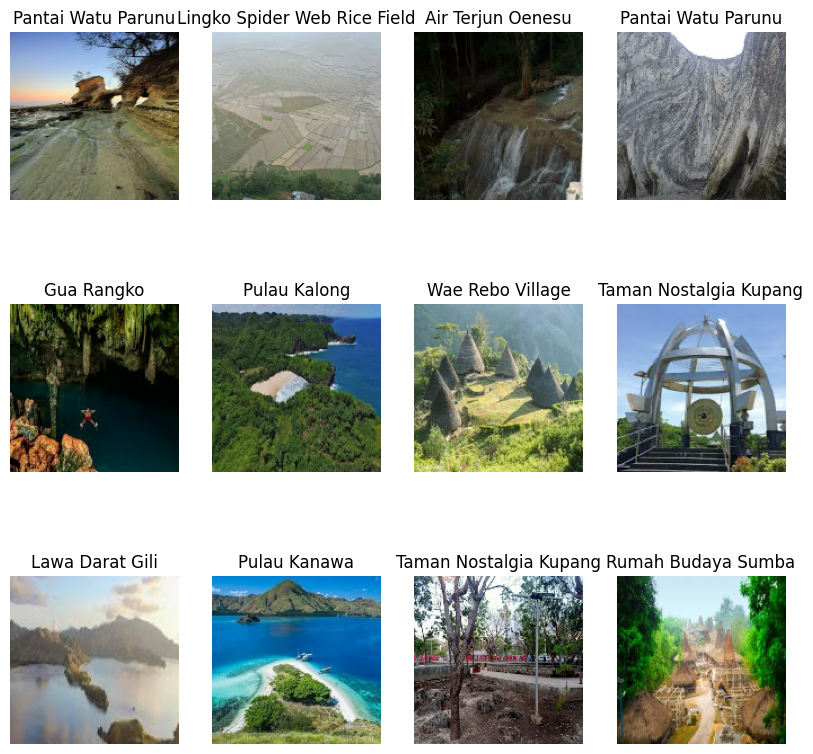

In [37]:
#Data Visualization
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.numpy().shape)
    print(labels_batch.numpy())
    #num_images = image_batch.shape[0]
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [38]:
data = dataset.map(lambda x,y: (x/225.0, y))


In [39]:
data.as_numpy_iterator().next()[0].min()

0.0

In [40]:
data.as_numpy_iterator().next()[0].max()

1.1333333

In [41]:
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - val_size

In [42]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size)

In [43]:
len(train_dataset)

208

In [44]:
len(test_dataset)

27

In [45]:
len(val_dataset)

26

In [46]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [47]:
pre_trained_model = MobileNetV2(weights="imagenet",
                                include_top=False,
                                input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

In [48]:
from tensorflow.keras.regularizers import l2
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(25, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

In [49]:
int_lr = 1e-4
num_epochs = 10

#optimizer = tf.optimizers.SGD(learning_rate=int_lr, momentum=0.9)
#optimizer = tf.optimizers.RMSprop()
optimizer = tf.optimizers.Adam(learning_rate = int_lr)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [50]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.85):
      print('val_accuracy > 0.82')
      self.model.stop_training = True


mycallback = myCallback()

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.1)

H = model.fit(train_dataset,
              epochs=num_epochs,
              validation_data=val_dataset,
              callbacks=[early_stopping],
              #callbacks = mycallback
              )


Epoch 1/10
208/208 [==============================] - 63s 221ms/step - loss: 2.3873 - accuracy: 0.4790 - val_loss: 1.0988 - val_accuracy: 0.7260
Epoch 2/10
208/208 [==============================] - 32s 151ms/step - loss: 0.8462 - accuracy: 0.7668 - val_loss: 0.9822 - val_accuracy: 0.7452
Epoch 3/10
208/208 [==============================] - 30s 143ms/step - loss: 0.4609 - accuracy: 0.8630 - val_loss: 0.9758 - val_accuracy: 0.7981
Epoch 4/10
208/208 [==============================] - 29s 141ms/step - loss: 0.2799 - accuracy: 0.9135 - val_loss: 1.0133 - val_accuracy: 0.7957
Epoch 5/10
208/208 [==============================] - 29s 139ms/step - loss: 0.1989 - accuracy: 0.9363 - val_loss: 0.9667 - val_accuracy: 0.7885
Epoch 6/10
208/208 [==============================] - 29s 138ms/step - loss: 0.1574 - accuracy: 0.9516 - val_loss: 0.9420 - val_accuracy: 0.8173


In [52]:
score = model.evaluate(test_dataset)

27/27 [==============================] - 11s 156ms/step - loss: 0.9503 - accuracy: 0.8028


In [53]:
score

[0.9502583146095276, 0.8027842044830322]

In [54]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

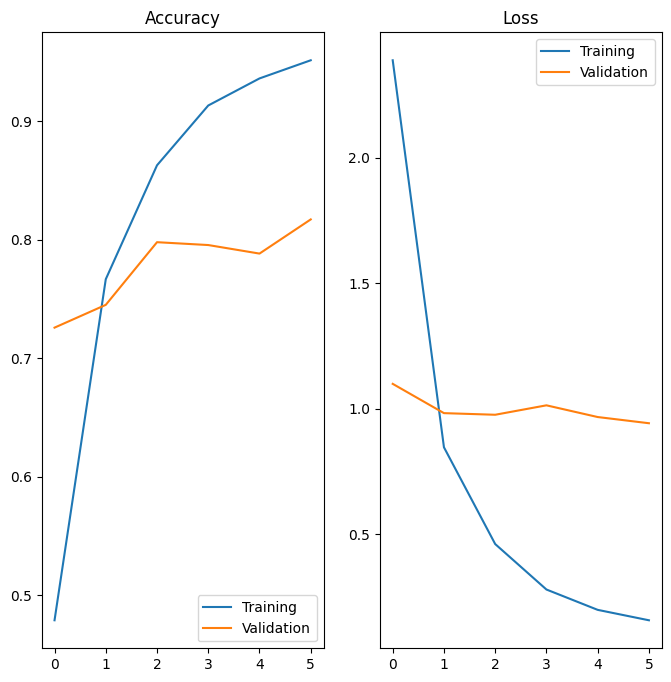

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(6), acc, label='Training')
plt.plot(range(6), val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(6), loss, label='Training')
plt.plot(range(6), val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

first image to predict
actual label: Pantai Koka
1/1 [==============================] - 2s 2s/step
predicted label: Pantai Koka
first image to predict
actual label: Gua Rangko
1/1 [==============================] - 0s 156ms/step
predicted label: Gua Rangko
first image to predict
actual label: Lingko Spider Web Rice Field
1/1 [==============================] - 0s 182ms/step
predicted label: Lingko Spider Web Rice Field


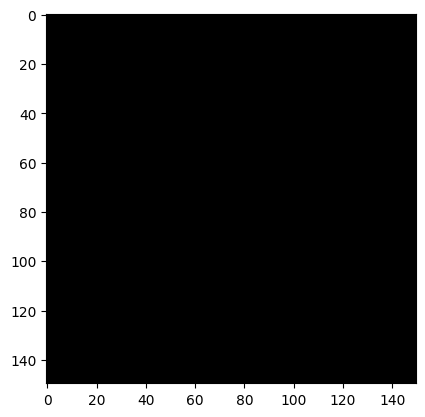

In [56]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(3):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 74ms/step


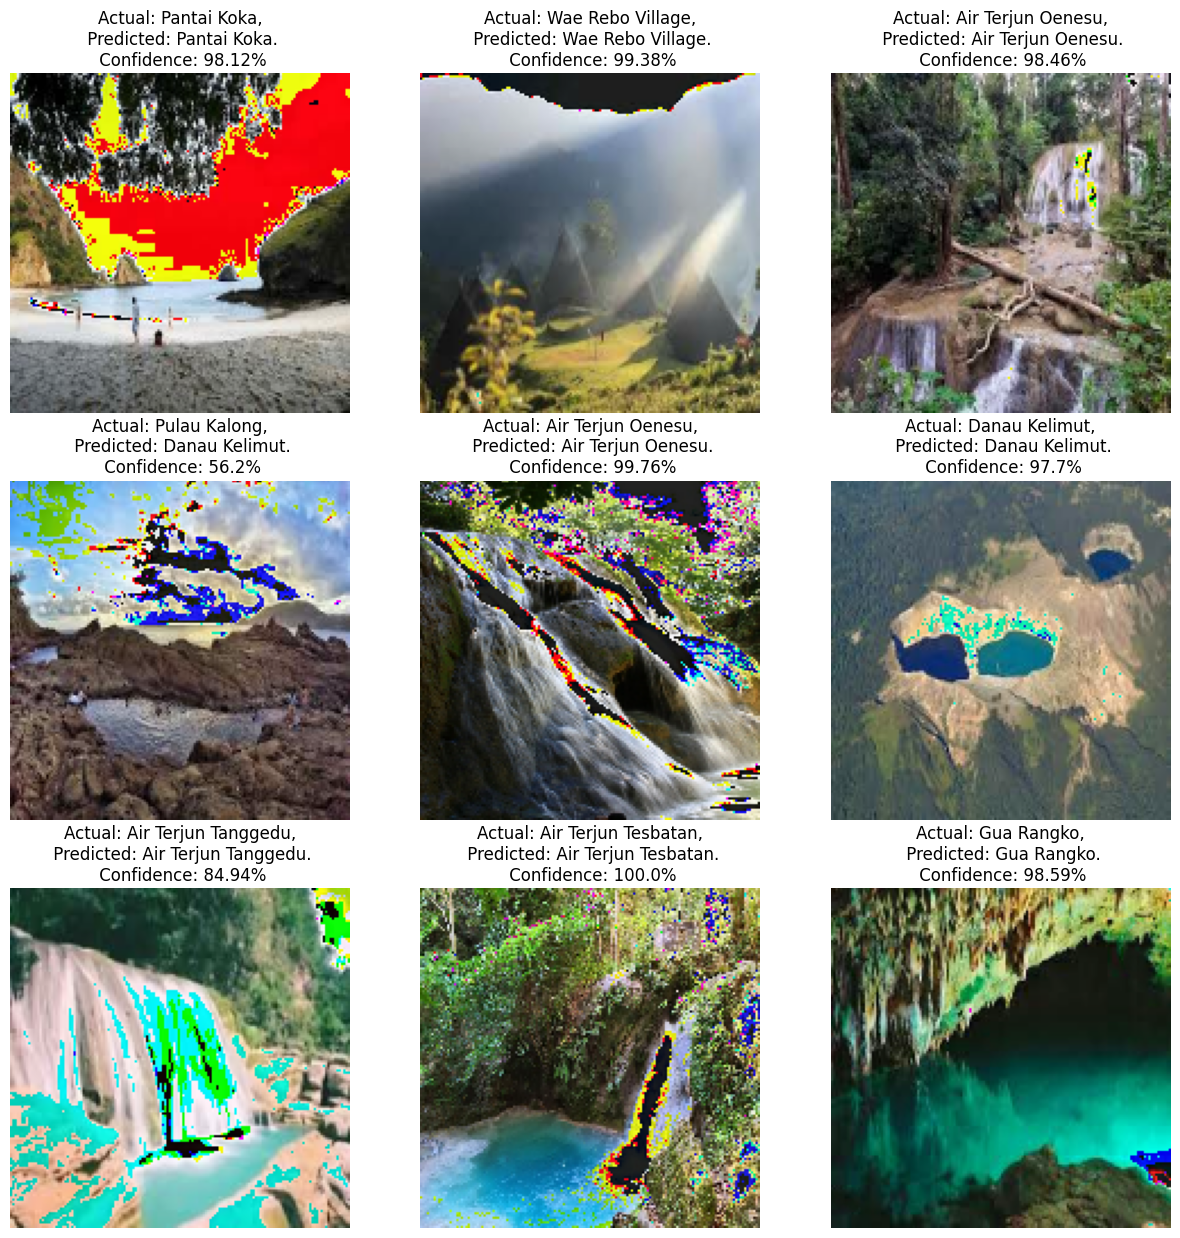

In [58]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images*256.0
        plt.imshow(image[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")